*Note: This notebook was created in Google Colab and is runnable there. It includes commands for setting up the environment, such as downloading data.*


In [1]:
!apt-get update -qq
!apt-get install -y megatools

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  megatools
0 upgraded, 1 newly installed, 0 to remove and 36 not upgraded.
Need to get 207 kB of archives.
After this operation, 898 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 megatools amd64 1.10.3-1build1 [207 kB]
Fetched 207 kB in 1s (140 kB/s)
Selecting previously unselected package megatools.
(Reading database ... 126308 files and directories currently installed.)
Preparing to unpack .../megatools_1.10.3-1build1_amd64.deb ...
Unpacking megatools (1.10.3-1build1) ...
Setting up megatools (1.10.3-1build1) ...
Processing triggers for man-db (2.10.2-1) ...


In [2]:
!megadl 'https://mega.nz/file/FLITlD7C#GbU0J0Yc3v9GLYKDm4os_a2-Ib9YTnBf5vwLSi4iC08'

Downloaded sign_lang_train.zip


In [ ]:
!unzip /content/sign_lang_train.zip -d /my_data/

#1. Imports

In [4]:
import os
import csv
import random
import numpy as np
from collections import defaultdict

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Set seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

# 2. Data Loading

In [5]:
print("2. Loading and splitting data...")
csv_path = '/my_data/sign_lang_train/labels.csv'
all_pairs = []
with open(csv_path, newline='') as f:
    for label, fname in csv.reader(f):
        all_pairs.append((label, fname))

# Group samples by class for stratified splitting
class_to_samples = defaultdict(list)
for label, fname in all_pairs:
    class_to_samples[label].append((label, fname))

# Stratified splitting
train_pairs, val_pairs, test_pairs = [], [], []
random.seed(42)

for class_name, samples in class_to_samples.items():
    random.shuffle(samples)
    n_samples = len(samples)
    n_train = int(0.7 * n_samples)
    n_val = int(0.15 * n_samples)
    train_pairs.extend(samples[:n_train])
    val_pairs.extend(samples[n_train:n_train + n_val])
    test_pairs.extend(samples[n_train + n_val:])

random.shuffle(train_pairs)
random.shuffle(val_pairs)
random.shuffle(test_pairs)

print(f"Total {len(all_pairs)} images → train {len(train_pairs)}, val {len(val_pairs)}, test {len(test_pairs)}")

1. Loading and splitting data...
Total 9680 images → train 6767, val 1438, test 1475


# 3. Preprocessing and Augmentation

In [6]:
print("\n3. Setting up data pipelines...")
DATA_ROOT = '/my_data/sign_lang_train/'
class_names = list(map(str, range(10))) + list('abcdefghijklmnopqrstuvwxyz')
NUM_CLASSES = len(class_names)

IMG_SIZE = (128, 128)
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE

random_rotation = tf.keras.layers.RandomRotation(factor=0.15, seed=42)

def parse_image(file_path, label, augment=False):
    """Parses a single image file."""
    label = tf.cast(label, tf.int32)
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=1)
    img = tf.image.resize(img, [IMG_SIZE[0], IMG_SIZE[1]])

    if augment:
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_brightness(img, max_delta=0.2)
        img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
        img = random_rotation(img)


    img = tf.cast(img, tf.float32) / 255.0
    return img, label

def make_lists(pairs):
    filepaths = [os.path.join(DATA_ROOT, fname) for label, fname in pairs]
    labels    = [class_names.index(label)        for label, fname in pairs]
    return filepaths, labels

train_files, train_labels = make_lists(train_pairs)
val_files,   val_labels   = make_lists(val_pairs)
test_files,  test_labels  = make_lists(test_pairs)


2. Setting up data pipelines...


# 4. Enhanced data pipeline

In [7]:
def make_dataset(files, labels, is_training=True):
    ds = tf.data.Dataset.from_tensor_slices((files, labels))
    if is_training:
        ds = ds.shuffle(len(files), seed=42)
        ds = ds.map(lambda x, y: parse_image(x, y, augment=True), num_parallel_calls=AUTOTUNE)
    else:
        ds = ds.map(lambda x, y: parse_image(x, y, augment=False), num_parallel_calls=AUTOTUNE)

    ds = ds.batch(BATCH_SIZE)
    return ds.prefetch(AUTOTUNE)

train_ds = make_dataset(train_files, train_labels, is_training=True)
val_ds   = make_dataset(val_files, val_labels, is_training=False)
test_ds  = make_dataset(test_files, test_labels, is_training=False)

# 5. Model Architecture

In [8]:
print("\n5. Creating the CNN model")
def create_model(num_classes, input_shape):
    """Creates a CNN model"""
    model = models.Sequential([
        layers.Input(shape=input_shape),

        # Block 1
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Block 2
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Block 3
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),


        # Block 4
        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Flatten(),

        # Dense layers
        layers.Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        layers.Dense(num_classes, activation='softmax')
    ])
    return model

model = create_model(NUM_CLASSES, IMG_SIZE + (1,))

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()



5. Creating the CNN model


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     8,389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 36)             │        18,468 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,799,396 (33.57 MB)

 Trainable params: 8,797,412 (33.56 MB)

 Non-trainable params: 1,984 (7.75 KB)

# 6. Callbacks

In [9]:
print("\n6. Setting up callbacks...")
callbacks = [
    ModelCheckpoint(
        'best_sign_lang_cnn.h5',
        save_best_only=True,
        monitor='val_accuracy',
        mode='max',
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
]


6. Setting up callbacks...


#7. Training the model

In [ ]:
print("\n7. Starting model training...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=callbacks,
    verbose=1
)

# 8. Evaluation on test set

In [11]:
print("\n8. Evaluating the model on the test set...")
model.load_weights('best_sign_lang_cnn.h5')
test_loss, test_accuracy = model.evaluate(test_ds, verbose=1)
print(f"\nFinal Test Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


8. Evaluating the model on the test set...
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9620 - loss: 0.3593

Final Test Results:
Test Loss: 0.3611
Test Accuracy: 0.9614


# 9. Results plotting


9. Plotting training history...


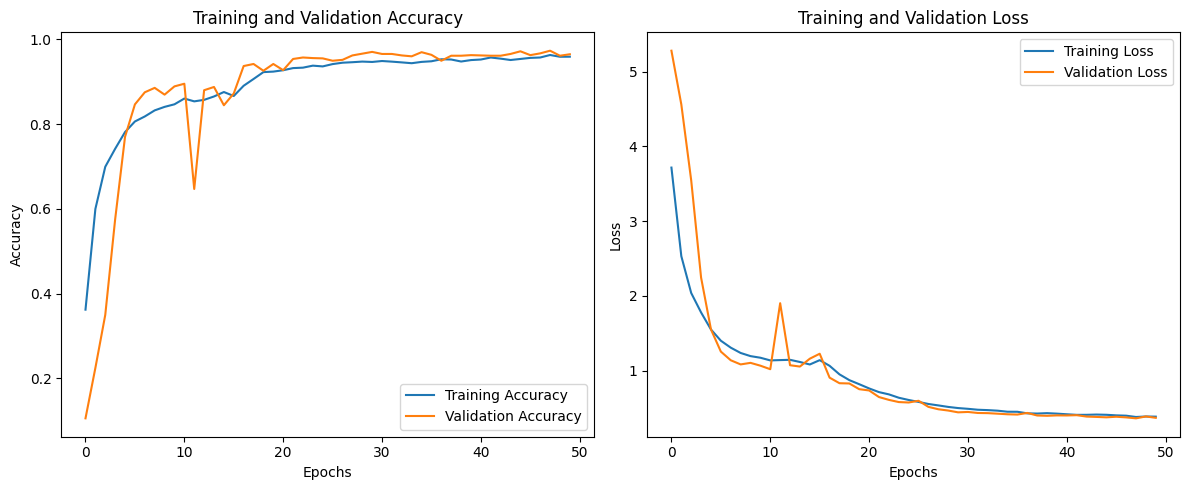

In [14]:
print("\n9. Plotting training history...")
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.tight_layout()
    plt.show()

plot_training_history(history)

#10. Confusion Matrix


10. Generating confusion matrix...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


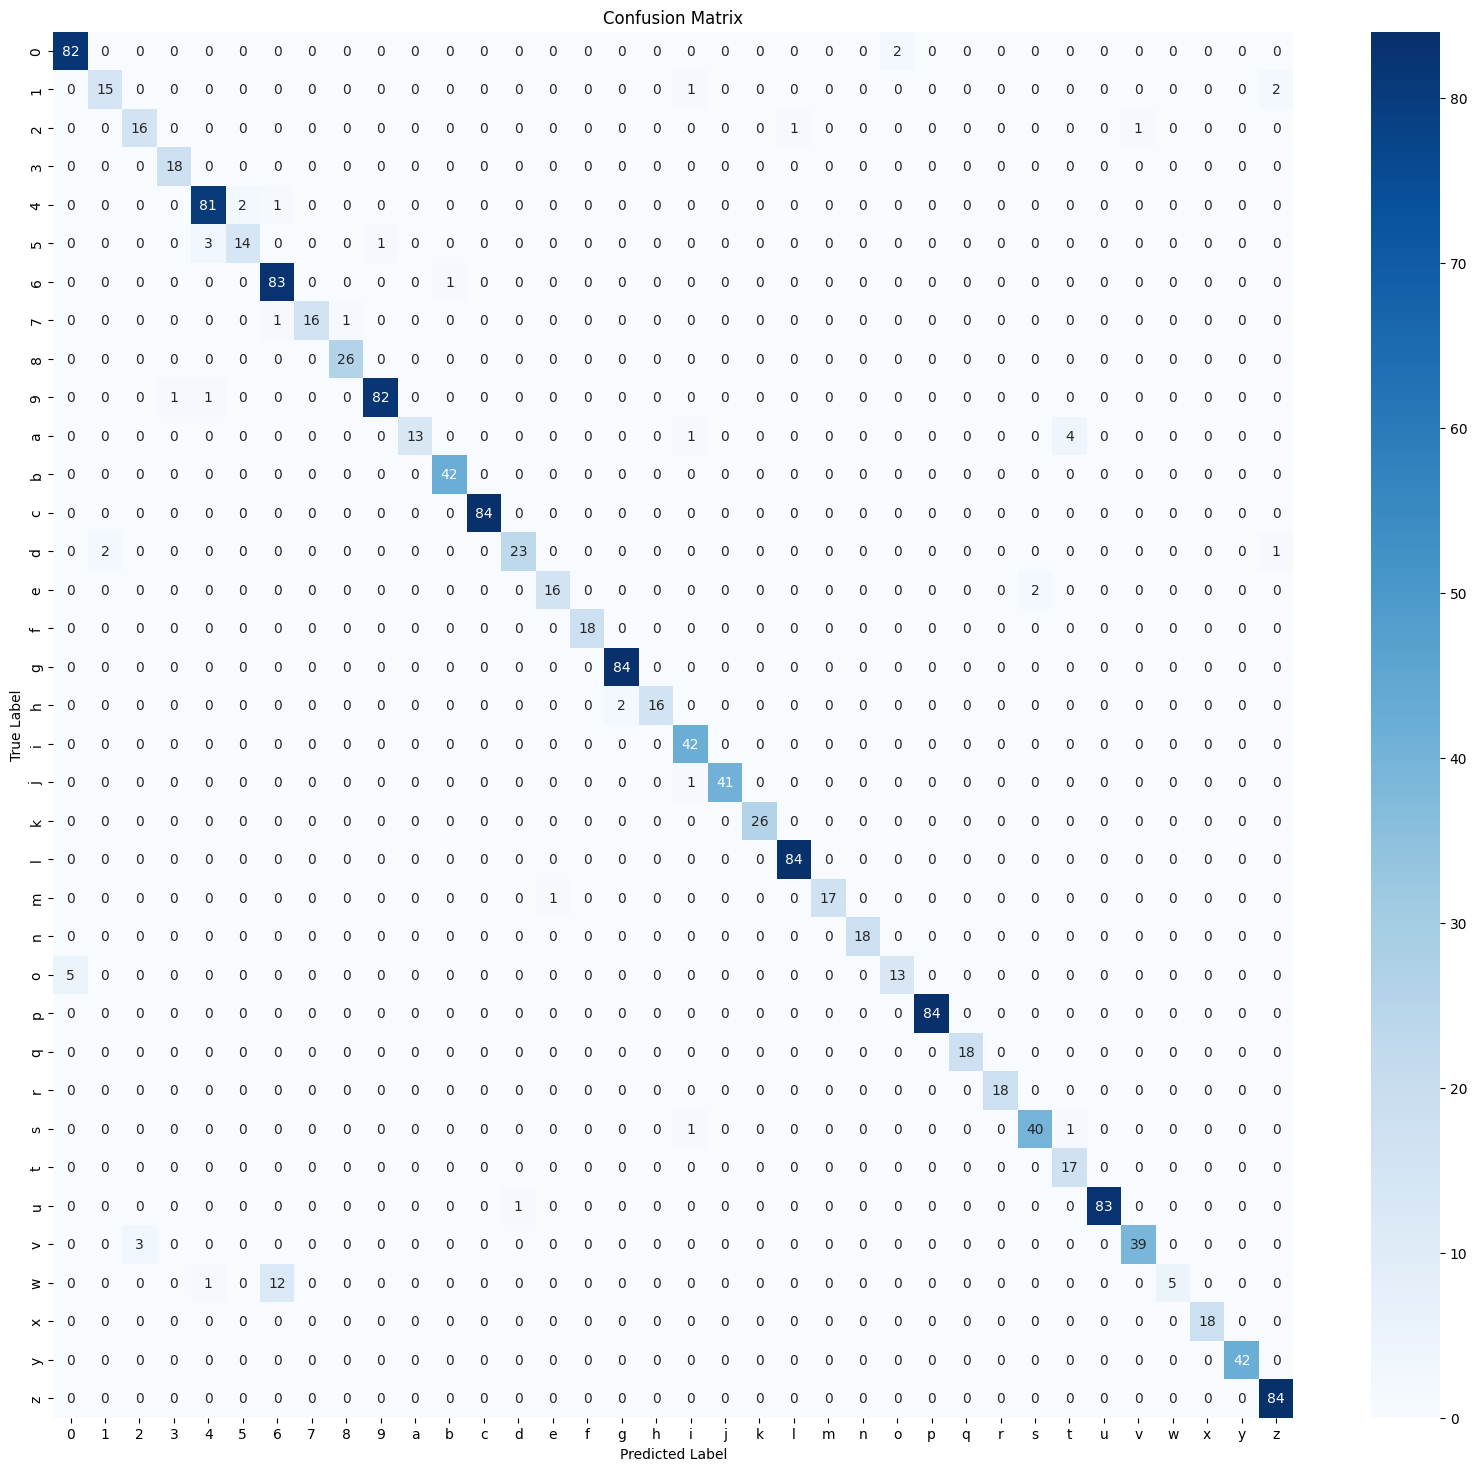

In [15]:
print("\n10. Generating confusion matrix...")
test_labels_flat = []
test_predictions_flat = []

for images, labels in test_ds:
    test_labels_flat.extend(labels.numpy())
    predictions = model.predict(images)
    test_predictions_flat.extend(np.argmax(predictions, axis=1))

cm = confusion_matrix(test_labels_flat, test_predictions_flat)

plt.figure(figsize=(20, 18))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 11. Post-training model quantization (to meet the under 50MB requirement)

In [20]:
loaded_model = tf.keras.models.load_model('best_sign_lang_cnn.h5')

converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()

with open('quantized_model.tflite', 'wb') as f:
    f.write(tflite_model)

print("Post-training quantization applied and model saved as 'quantized_model.tflite'")

Saved artifact at '/tmp/tmpe1jq5try'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 36), dtype=tf.float32, name=None)
Captures:
  138263227777296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138263227779408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138263227777680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138263227779984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138263227777488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138263227779216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138263227780368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138263227781712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138263227781136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138263227782288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13826322778094

# 11. Evaluate model size and accuracy

In [21]:
quantized_model_size = os.path.getsize('quantized_model.tflite')
print(f"Quantized model size: {quantized_model_size / (1024 * 1024):.2f} MB")

interpreter = tf.lite.Interpreter(model_path='quantized_model.tflite')

interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

test_images = []
test_labels_eval = []
for images, labels in test_ds:
    test_images.append(images.numpy())
    test_labels_eval.append(labels.numpy())

test_images = np.concatenate(test_images, axis=0)
test_labels_eval = np.concatenate(test_labels_eval, axis=0)

input_dtype = input_details[0]['dtype']
test_images = test_images.astype(input_dtype)


tflite_predictions = []
for i in range(len(test_images)):
    input_tensor = tf.constant(test_images[i:i+1])
    interpreter.set_tensor(input_details[0]['index'], input_tensor)
    interpreter.invoke()
    output_tensor = interpreter.get_tensor(output_details[0]['index'])
    tflite_predictions.append(output_tensor[0])

tflite_predictions = np.array(tflite_predictions)

tflite_predicted_indices = np.argmax(tflite_predictions, axis=1)

correct_predictions = np.sum(tflite_predicted_indices == test_labels_eval)
tflite_accuracy = correct_predictions / len(test_labels_eval)

print(f"Quantized model test accuracy: {tflite_accuracy:.4f}")

try:
    print(f"Original model test accuracy: {test_accuracy:.4f}")
except NameError:
    print("Original model test accuracy not available (run the training cell first).")

Quantized model size: 8.41 MB
Quantized model test accuracy: 0.9173
Original model test accuracy: 0.9614
